In [139]:
import pandas as pd
import numpy as np
import plotly.express as px
import pydotplus
from subprocess import check_call
from graphviz_sql.extract import to_sql 
import seaborn as sns
from imblearn.over_sampling import SMOTE
import sqlite3
import pickle
from scipy import stats
import sys
import argparse
import os
import time
import itertools


%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')   
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import svm, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris





In [179]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [180]:
def assign_to_teams(model, X_test):
    leaf_indices = model.apply(X_test)
    return leaf_indices



def find_distributions(model, data):
    X_test = data.drop(columns=["price"])
    y_test = data[["price"]]
    y_predict = model.predict(X_test)
    #y_predict = (y_predict > 0.5).astype(int)
    y_test_DT = y_test.reset_index()
    y_predict_DT = pd.DataFrame(y_predict, columns = ['predict'])
    data_M2 = pd.concat([y_test_DT, y_predict_DT], axis=1, join='inner')
    data_M2['result'] = np.where(data_M2["price"]==data_M2['predict'],'0','1')
    data_M2.set_index(["index"], inplace=True)
    data_M2 = pd.concat([data_M2, X_test], axis=1, join='inner')
    
    x_DT = data_M2.drop(columns=["price", "result", "predict"])
    y_DT = data_M2[["result"]]
    #print(data_M2.info())
    #print(data_M2.result.value_counts())
    X_train_DT, X_test_DT, y_train_DT, y_test_DT = train_test_split(x_DT, y_DT, test_size=0.5, random_state=42)
    ### SMOTE
    # y_train_DT = y_train_DT.astype('int')
    # oversample = SMOTE(random_state=42)
    # X_balance_DT,Y_balance_DT = oversample.fit_resample(X_train_DT,y_train_DT)
    # X_balance_DT = pd.DataFrame(X_balance_DT, columns = X_train_DT.columns)
    #train Decision tree
    # model_DT = DecisionTreeClassifier(
    #     max_depth=17,
    #      #                             min_samples_split=20,
    #                                   random_state=42
    #                            )
    # model_DT = DecisionTreeClassifier(
    #     criterion='entropy',
    #     max_depth=15,
    #     min_samples_split=20,
    #     min_samples_leaf=5,
    #     max_features='sqrt',
    #     random_state=42
    # )
    from sklearn.model_selection import GridSearchCV

    # Define the parameter grid for 'max_depth' and 'min_samples_leaf'
    param_grid = {
        'max_depth': range(3, 15),  # Testing max_depth values from 3 to 10
        'min_samples_leaf': [int(x) for x in np.linspace(start=0.01 * len(X_train_DT), stop=0.05 * len(X_train_DT), num=5)]  # 1% to 5% of the dataset
    }

    # Create the Decision Tree model
    model_DT_ori = DecisionTreeClassifier(random_state=42)

    # Set up GridSearchCV with 10-fold cross-validation
    grid_search = GridSearchCV(estimator=model_DT_ori, param_grid=param_grid, cv=10, scoring='accuracy')

    # Fit the grid search to the data (assuming X and y are your features and target variable)
    grid_search.fit(X_train_DT, y_train_DT)

    # Get the best parameters
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")

    # Create a new model with the best parameters
    model_DT = DecisionTreeClassifier(**best_params, random_state=42)
    model_DT.fit(X_train_DT, y_train_DT)
    y_test_DT = y_test_DT.astype('int')
    y_predict_DT = model_DT.predict(X_test_DT)
    
    teams = assign_to_teams(model_DT, X_test)

 

    data_M2['team'] = teams
    #print(data_M2.team.value_counts())
    
        # Group by 'team' and calculate the value counts for 'result'
    df1 = data_M2['team'].value_counts().to_frame()

    # Calculate the accuracy for each team
    g = data_M2.groupby("team")
    m = g['result'].value_counts(normalize=True,sort=False)
    acc = m.loc[:,'0'].to_frame()

    # Combine the count and accuracy data
    List_accuracy = pd.concat([acc, df1], axis=1, join='inner')
    accuracy_team = List_accuracy.reset_index()

    accuracy_team['percentage'] = accuracy_team['team'] / len(X_test)

    accuracy_team = accuracy_team.rename(columns={'team':'count'})
    accuracy_team = accuracy_team.rename(columns={'result':'Accuracy'})
    accuracy_team = accuracy_team.rename(columns={'index':'Team_number'})
    #print(f"accuracy_team:\n {accuracy_team}")
    return accuracy_team, model_DT
    
#     ##save DT tree plan dot
#     dot_data=tree.export_graphviz(model_DT, out_file='/Users/sdong/phd_doc/att/Fraud/image/tree_DT_Interpretable_pipeline_test.dot', feature_names= x_DT.columns,
#                                class_names=['0', '1'], node_ids=True,
#                               filled=True, rounded=True,  
#                               special_characters=True)
#     check_call(['dot','-Tpng','/Users/sdong/phd_doc/att/Fraud/image/tree_DT_Interpretable_pipeline_test.dot','-o','/Users/sdong/phd_doc/att/Fraud/image/tree_DT_Interpretable_CatBoost_3.png'])
#     ##save sql doc
#     to_sql('/Users/sdong/phd_doc/att/Fraud/image/tree_DT_Interpretable_pipeline_test.dot', '/Users/sdong/phd_doc/att/Fraud/image/tree_DT_Interpretable_pipeline_test.sql')
    
#     X_test['predict'] = y_predict
#     X_test['result'] = np.where(y_test['price']==X_test['predict'],'0','1')
#     data_result = X_test
#     data_result['team'] = 0
#     df = data_result
#     #connect to a database
#     conn = sqlite3.connect("pipleine_ourM3.db") #if the db does not exist, this creates a Any_Database_Name.db file in the current directory
#     #store your table in the database:
#     df.to_sql('Some_Table_Name', conn)
#     #read a SQL Query out of your database and into a pandas dataframe
#     sql_string = 'SELECT * FROM Some_Table_Name'
#     df = pd.read_sql(sql_string, conn)
#     # Open and read the file as a single buffer
#     fd = open('/Users/sdong/phd_doc/att/Fraud/image/tree_DT_Interpretable_pipeline_test.sql', 'r')
#     sqlFile = fd.read()
#     fd.close()
#     ## prepare sql document
#     sqlFile=sqlFile.replace('select case', 'UPDATE Some_Table_Name \nSET team = \nCASE')
#     n=sqlFile.count('then 0 ')

#     sqlFile = sqlFile.replace('then 0 ', 'then -xxx')
#     for i in range(n):
#         sqlFile = sqlFile.replace('-xxx', str(-i), 1)

#     m=sqlFile.count('then 1 ')
#     sqlFile = sqlFile.replace('then 1 ', 'then +xxx')
#     for i in range(m):
#         sqlFile = sqlFile.replace('+xxx', str(i+1), 1)
#     fd = open('/Users/sdong/phd_doc/att/Fraud/image/tree_DT_Interpretable_pipeline_test.sql', 'w+')
#     fd.write(sqlFile)
#     fd.close()

#     ## compile sql doc
#     sql_string = sqlFile.split(';')
#     cur = conn.cursor()
#     for command in sql_string:
#         cur.execute(command)
#     os.remove("pipleine_ourM3.db")
#     ##read data from database
#     sql_string='SELECT * FROM Some_Table_Name;'
#     df = pd.read_sql(sql_string, conn)
#     df1= df.team.value_counts()
#     df1.to_csv("/Users/sdong/phd_doc/att/Fraud/data/Black_box_team_count_pepiline.csv")    
#     g = df.groupby("team")
#     m=g['result'].value_counts(normalize=True,sort=False)
#     acc=m.loc[-400:400,'0']
#     acc=acc.to_frame()
#     acc.to_csv("/Users/sdong/phd_doc/att/Fraud/data/Black_box_acc_result_pipeline.csv")    
#     df1=pd.read_csv("/Users/sdong/phd_doc/att/Fraud/data/Black_box_team_count_pepiline.csv")
#     df1.set_index(["Unnamed: 0"], inplace=True)
#     df1 = df1.rename_axis('Team_number')
#     df1 = df1.rename(columns={'team': 'account'})
#     acc = pd.read_csv("/Users/sdong/phd_doc/att/Fraud/data/Black_box_acc_result_pipeline.csv")
#     acc=acc[['team','result.1']]
#     acc.set_index(["team"], inplace=True)
#     acc = acc.rename_axis('Team_number')
#     acc = acc.rename(columns={'result.1': 'Accuracy'})
#     List_accuracy = pd.concat([acc, df1], axis=1, join='inner')
#     accuracy_team=List_accuracy.reset_index()
    
#     #low_accuracy_teams=low_accuracy_teams.reset_index() 
#     accuracy_team['percentage']= accuracy_team['account']/len(X_test)
#     # low_accuracy_teams = accuracy_team.loc[accuracy_team['Accuracy'] < 0.7741]
# #     X = low_accuracy_teams['Team_number']
# #     y = low_accuracy_teams['percentage']

# #     # 创建柱状图
# #     plt.bar(X, y)

# #     # 设置 X 轴和 Y 轴标签
            

# #     # 显示图形
# #     plt.show()

#     return accuracy_team
    


In [181]:
# 定义检测函数
from scipy.stats import ks_2samp
def drift_detection(X_train, X_test, threshold=0.05):
    """
    检测数据分布是否漂移
    """
    # 提取特征列表
    features = X_train.columns.tolist()

    # 初始化检测结果列表
    results = []

    # 针对每个特征，计算p-value和KS统计量
    for feature in features:
        # 获取训练数据和测试数据中的该特征的值
        train_values = X_train[feature].values
        test_values = X_test[feature].values

        # 计算KS统计量和p-value
        ks_statistic, p_value = ks_2samp(train_values, test_values)

        # 判断是否漂移
        if p_value < threshold:
            drift = True
        else:
            drift = False

        # 记录检测结果
        results.append({
            "feature": feature,
            "p_value": p_value,
            "ks_statistic": ks_statistic,
            "drift": drift
        })
        
    is_drift = any([result["drift"] for result in results])
        
    # 返回结果列表
    return is_drift

In [182]:
# from sklearn.metrics.pairwise import rbf_kernel
# from scipy.spatial.distance import cdist
# def mmd_fast(X, Y, sigma=None):
#     """
#     高斯核的MMD值计算函数，使用Nystrom方法加速计算
#     X: ndarray, shape (n_samples_X, n_features)
#     Y: ndarray, shape (n_samples_Y, n_features)
#     sigma: float, 高斯核的带宽参数
#     """
#     X=X.values
#     Y=Y.values
#     n_samples_X, n_samples_Y = X.shape[0], Y.shape[0]

#     # 计算高斯核矩阵
#     K_XX = rbf_kernel(X, X, gamma=1/(2*sigma**2)) if n_samples_X <= 5000 else rbf_kernel(X[:5000], X[:5000], gamma=1/(2*sigma**2))
#     K_YY = rbf_kernel(Y, Y, gamma=1/(2*sigma**2)) if n_samples_Y <= 5000 else rbf_kernel(Y[:5000], Y[:5000], gamma=1/(2*sigma**2))
#     K_XY = rbf_kernel(X, Y, gamma=1/(2*sigma**2)) if n_samples_X <= 5000 and n_samples_Y <= 5000 else rbf_kernel(X[:5000], Y[:5000], gamma=1/(2*sigma**2))

#     # 计算MMD值
#     mmd = (np.sum(K_XX) / (n_samples_X * (n_samples_X - 1)) + np.sum(K_YY) / (n_samples_Y * (n_samples_Y - 1)) - 2 * np.sum(K_XY) / (n_samples_X * n_samples_Y))
    
#     # 根据MMD值判断是否存在数据漂移
#     is_drift_mmd=False
#     if mmd > 0.001:
#         is_drift_mmd=True
#     return is_drift_mmd
# Compute MMD (maximum mean discrepancy) using numpy and scikit-learn.

import numpy as np
from sklearn import metrics

def mmd_fast(X, Y, gamma=1.0):
    """MMD using rbf (gaussian) kernel (i.e., k(x,y) = exp(-gamma * ||x-y||^2 / 2))

    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]

    Keyword Arguments:
        gamma {float} -- [kernel parameter] (default: {1.0})

    Returns:
        [scalar] -- [MMD value]
    """
    XX = metrics.pairwise.rbf_kernel(X, X, gamma)
    YY = metrics.pairwise.rbf_kernel(Y, Y, gamma)
    XY = metrics.pairwise.rbf_kernel(X, Y, gamma)
    mmd = XX.mean() + YY.mean() - 2 * XY.mean()
        # 根据MMD值判断是否存在数据漂移
    print(f'mmd : {mmd}')
    is_drift_mmd=False
    if mmd > 0.00001:
        is_drift_mmd=True
    return is_drift_mmd

In [183]:
####  H-D
join=os.path.join
from sklearn.decomposition import PCA
# parser = argparse.ArgumentParser()

# parser.add_argument('--n', type=int, default=300)
# parser.add_argument('--seed', type=int, default=1)
# parser.add_argument('--log_dir', type=str, default='logs')
# parser.add_argument('--runs', type=int, default=1)

n=200
seed=1
log_dir='logs'
runs=1
bandwidth = 'scott'
max_data_size = n
# args = parser.parse_args()

np.random.seed(seed)

def get_kde_estimates(bandwidth, data) :
	# kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
	data = data.T
	kernel = stats.gaussian_kde(data, bandwidth)
	return kernel.evaluate(data)




if not os.path.exists(log_dir):
	os.makedirs(log_dir)




fname = join(log_dir, 'result_' + str(max_data_size) + '.txt')

def in_top_k(scores, k):
    indices = np.argsort(scores)[::-1]
    pos = np.where(indices==0)[0][0]
    print(f"pos:{pos}")
    return pos <= k

def evaluate(data_1,data_2):
    scores = []
    data1 = data_1.sample(n=200,  random_state=42).to_numpy()
    data2 = data_2.to_numpy()
  
    for rep in range(100):

        if rep != 0:
            data_all = np.concatenate([data1, data2], axis=0)
            data_all = data_all[np.random.permutation(range(data_all.shape[0]))]
            data1 = data_all[:max_data_size]
            data2 = data_all[max_data_size:]
        datam = np.concatenate([data1[:max_data_size//2], data2[:max_data_size//2]], axis=0)
        pca = PCA(n_components=5)
        # 将13维数组X降维到4维
        data1 = pca.fit_transform(data1)
        data2 = pca.fit_transform(data2)
        datam = pca.fit_transform(datam)
        logprob_1 = get_kde_estimates(bandwidth, data1)
        logprob_2 = get_kde_estimates(bandwidth, data2)
        logprob_m = get_kde_estimates(bandwidth, datam)

        vdiv = np.mean(-logprob_m) - min(np.mean(-logprob_1), np.mean(-logprob_2))
        with open(fname, 'a') as f:
            f.write("Scores " + str(np.mean(logprob_1)) + " " + str(np.mean(logprob_2)) + " " + str(np.mean(logprob_m)) + "\n")
        scores.append(vdiv)

    return in_top_k(scores, k=90)





In [248]:
data_df = pd.read_csv("./CER/xT_residential_25728.csv")
labels = pd.read_csv("./CER/labels/tumbledryer_case.csv")
labels.set_index('id_pdl', inplace=True)
labels.index.name = None
labels.index = labels.index.astype(int)
labels.head()
labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4225 entries, 1002 to 7444
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   label   4225 non-null   int64
dtypes: int64(1)
memory usage: 66.0 KB


In [249]:
data_train= data_df.head(1001)
data_train.head()

,index,0,1,2,3,4,5,6,7,8,...,4215,4216,4217,4218,4219,4220,4221,4222,4223,4224
0,id_pdl,1002.000,1003.000,1004.000,1005.000,1006.000,1008.000,1009.000,1013.000,1014.000,...,7433.000,7434.000,7435.000,7436.000,7437.000,7438.000,7440.000,7441.000,7442.000,7443.000
1,0,0.362,0.692,1.310,0.177,0.048,0.860,0.614,0.209,0.204,...,0.549,0.134,0.541,0.168,0.256,0.023,0.304,0.289,0.584,0.148
2,1,0.064,0.381,1.142,0.172,0.086,0.371,0.554,0.206,0.393,...,0.256,0.117,0.282,0.166,0.219,0.001,0.188,0.187,0.207,0.148
3,2,0.119,0.380,1.218,0.152,0.097,0.413,0.588,0.138,0.210,...,0.203,0.039,0.072,0.165,0.304,0.025,0.157,0.120,0.196,0.134
4,3,0.023,0.379,0.903,0.158,0.045,0.396,0.622,0.131,0.153,...,0.151,0.039,0.114,0.164,0.238,0.015,0.227,0.103,0.196,0.167


In [250]:
data_train_transposed = data_train.transpose()
#data_train_transposed.columns = data_train.iloc[0]
data_train_transposed = data_train_transposed[1:]
data_train_transposed.set_index(0, inplace=True)
data_train_transposed.index.name = None
data_train_transposed.index = data_train_transposed.index.astype(int)
data_train = pd.concat([labels, data_train_transposed], axis=1)
data_train.head()

,label,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
1002,0.0,0.362,0.064,0.119,0.023,0.14,0.036,0.108,0.083,0.056,...,0.139,0.022,0.111,0.085,0.047,0.142,0.019,0.117,0.086,0.047
1003,1.0,0.692,0.381,0.38,0.379,0.346,0.266,0.28,0.346,0.383,...,0.321,0.318,0.319,0.317,0.207,0.205,0.233,0.324,0.319,0.318
1004,1.0,1.31,1.142,1.218,0.903,0.79,0.814,0.924,0.537,0.296,...,4.831,2.363,0.558,0.456,0.471,1.275,0.965,1.297,1.714,3.077
1005,1.0,0.177,0.172,0.152,0.158,0.159,0.146,0.165,0.141,0.164,...,0.276,0.237,0.904,1.859,0.496,0.193,0.26,0.28,0.313,0.377
1008,1.0,0.86,0.371,0.413,0.396,0.384,0.309,0.154,0.251,0.155,...,1.692,0.626,0.375,0.482,0.421,0.55,0.436,1.283,2.469,1.571


In [251]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4968 entries, 1002 to 7441
Columns: 1001 entries, label to 1000
dtypes: float64(1), object(1000)
memory usage: 38.0+ MB


In [252]:
# data_test= data_df.iloc[[0] + list(range(8000, 9000))]

# # data_test.head()
# data_test_transposed = data_test.transpose()
# #data_train_transposed.columns = data_train.iloc[0]
# data_test_transposed = data_test_transposed[1:]
# data_test_transposed.set_index(0, inplace=True)
# data_test_transposed.index.name = None
# data_test_transposed.index = data_test_transposed.index.astype(int)
# data_test_transposed.columns = data_train_transposed.columns
# data_test = pd.concat([labels, data_test_transposed], axis=1)
# data_test.head()
# 定义一个空的 DataFrame，用于存储所有的 data_test
all_data_test = pd.DataFrame()

# 循环15次，每次增加1000的索引范围
for i in range(6, 10):
    start = i * 1000
    end = start + 1000
    data_test = data_df.iloc[[0] + list(range(start, end))]
    
    data_test_transposed = data_test.transpose()
    data_test_transposed = data_test_transposed[1:]
    data_test_transposed.set_index(0, inplace=True)
    data_test_transposed.index.name = None
    data_test_transposed.index = data_test_transposed.index.astype(int)
    data_test_transposed.columns = data_train_transposed.columns
    data_test = pd.concat([labels, data_test_transposed], axis=1)
    num_samples = int(len(data_test) * 0.5)

    #获取前百分之10的数据
    data_test = data_test.head(num_samples)
    
    # 把每次得到的 data_test 添加到 all_data_test 中
    all_data_test = pd.concat([all_data_test, data_test])
    

all_data_test.head()


,label,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
1002,0.0,0.523,0.43,0.087,0.024,0.146,0.147,0.145,0.144,0.143,...,0.107,0.108,0.17,0.316,0.244,0.249,0.303,0.198,0.293,0.271
1003,1.0,0.646,0.542,0.518,0.653,0.618,0.65,0.461,0.536,0.435,...,0.315,0.205,0.199,0.309,0.574,3.633,1.96,0.989,1.37,1.006
1004,1.0,0.696,0.682,0.599,0.438,0.449,0.519,0.451,0.47,0.477,...,0.77,0.877,1.486,0.669,1.056,1.111,1.082,1.144,1.061,1.138
1005,1.0,0.633,0.598,0.23,0.159,0.143,0.15,0.154,0.158,0.147,...,0.168,0.261,0.171,0.18,0.152,0.27,0.167,0.254,0.198,0.337
1008,1.0,1.782,1.685,1.779,1.74,1.146,1.235,1.197,1.088,1.235,...,1.277,1.735,1.406,1.808,1.442,2.158,3.797,3.302,2.849,1.691


In [253]:
all_data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9936 entries, 1002 to 4786
Columns: 1001 entries, label to 1000
dtypes: float64(1), object(1000)
memory usage: 76.0+ MB


In [254]:
data_train.fillna(0, inplace=True)
all_data_test.fillna(0, inplace=True)

In [255]:
# # 计算要获取的数据数量
# num_samples = int(len(all_data_test) * 0.5)

# 获取前百分之10的数据
# test_data = all_data_test.head(num_samples)
test_data = all_data_test
# 计算要获取的测试数据数量
num_test_samples = int(len(data_train) * 0.5)

# 获取后百分之90的测试数据
train_data = data_train.tail(num_test_samples)
train_data.head()

,label,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
4787,1.0,0.205,0.213,0.264,0.250,0.277,0.246,0.287,0.220,0.246,...,0.310,0.235,0.190,0.188,0.113,0.513,0.674,0.576,0.694,1.562
4788,0.0,2.031,1.189,1.094,1.692,0.185,0.227,0.221,0.175,0.127,...,0.266,1.021,1.905,1.168,1.201,0.617,0.154,0.259,0.217,0.361
4791,0.0,0.059,0.063,0.032,0.060,0.039,0.059,0.037,0.046,0.052,...,0.053,0.045,0.059,0.038,0.059,0.038,0.060,0.038,0.058,0.055
4794,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4795,1.0,0.198,0.170,0.189,0.131,0.197,0.100,0.169,0.080,0.140,...,0.545,1.221,2.452,0.404,0.241,0.555,0.332,0.217,0.788,1.960


In [256]:
test_data.label.value_counts()

1.0    6912
0.0    3024
Name: label, dtype: int64

In [257]:
train_data.label.value_counts()

0.0    1322
1.0    1162
Name: label, dtype: int64

In [258]:
test_data.rename(columns={"label": "price"}, inplace=True)
train_data.rename(columns={"label": "price"}, inplace=True)

train_set=train_data
test_set=test_data

In [259]:
x = train_set.drop(columns=["price"])
y = train_set[["price"]]

# splitting the data
X_train_ML, X_test_ML, y_train_ML, y_test_ML = train_test_split(x, y, test_size=0.5, random_state=42)

from imblearn.over_sampling import SMOTE
y_train_ML = y_train_ML.astype('int')
oversample = SMOTE(random_state=42)
X_balance_ML,Y_balance_ML = oversample.fit_resample(X_train_ML,y_train_ML)
X_balance_ML = pd.DataFrame(X_balance_ML, columns = X_train_ML.columns)

CatBoost Accuracy Score is 0.57649
     0    1
0  413  255
1  271  303
[[0.61826347 0.38173653]
 [0.47212544 0.52787456]]


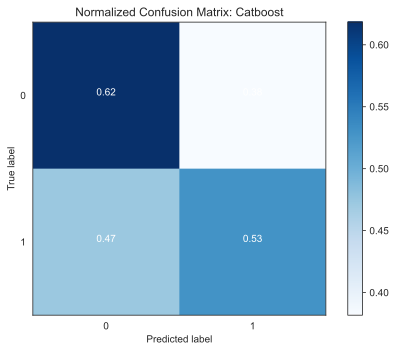

In [260]:
from xgboost import XGBClassifier
# model = LogisticRegression(C=1,
#                        random_state=42,
#                        solver='lbfgs')
###### LightGBM
# model = LGBMClassifier(num_leaves=31,
#                        max_depth=5, 
#                        learning_rate=0.02,
#                        n_estimators=100,
#                        subsample = 0.8,
#                        colsample_bytree =0.8
#                       )
# model = CatBoostClassifier(iterations=150,
#                            learning_rate=0.2,
#                            od_type='Iter',
#                            verbose=25,
#                            depth=16,
#                            random_seed=42)
# model = RandomForestClassifier(n_estimators=250,
#                       max_depth=12,
#                       min_samples_leaf=16,
#                                random_state=42
#                      )

#########XGBOOST
# model = XGBClassifier(max_depth=6,
#               n_estimators=100,
#               min_child_weight=8, 
#               subsample=0.8, 
#               learning_rate =0.02,    
#               seed=42)
model = svm.SVC( C=0.1,random_state=42)


#####################
# from keras.models import Sequential
# from keras.layers import Dense

# # 构建神经网络模型
# model = Sequential()
# # model.add(Dense(64, activation='relu', input_dim=14))
# # model.add(Dense(64, activation='relu'))
# # model.add(Dense(1, activation='sigmoid'))

# from keras.layers import Dropout
# from keras import regularizers



# 构建神经网络模型
# model = Sequential()
# model.add(Dense(32, activation='relu', input_dim=1000))
# model.add(Dropout(0.5))  # 添加 Dropout 层，随机丢弃50%的神经元
# model.add(Dense(16, activation='relu'))
# model.add(Dropout(0.5))  # 添加 Dropout 层，随机丢弃50%的神经元
# model.add(Dense(1, activation='sigmoid'))


# model.add(Dense(128, activation='relu', input_dim=14))
# model.add(Dense(128, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

# model.add(Dense(128, activation='relu', input_dim=14))
# model.add(Dense(1, activation='sigmoid'))

#     # 编译模型
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# from keras.callbacks import EarlyStopping

# 创建EarlyStopping回调
#early_stop = EarlyStopping(monitor='val_loss', patience=3)
# #     # 训练模型
#     model.fit(X_balance_ML, Y_balance_ML, epochs=10, validation_data=(X_test_ML, y_test_ML))
# 在模型训练时使用EarlyStopping回调
#model.fit(X_balance_ML, Y_balance_ML, epochs=10, validation_data=(X_test_ML, y_test_ML), callbacks=[early_stop])
model.fit(X_balance_ML, Y_balance_ML)
y_predict = model.predict(X_test_ML)
#y_predict = (y_predict > 0.5).astype(int)
acc_tre=accuracy_score(y_test_ML, y_predict)
print('CatBoost Accuracy Score is {:.5}'.format(accuracy_score(y_test_ML, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test_ML,y_predict)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test_ML,y_predict),
                      classes=class_names, normalize = True,
                      title='Normalized Confusion Matrix: Catboost')



In [261]:
import joblib
import pickle
    
filename = "/Users/sdong/phd_doc/att/Fraud/model/model_LR_test_fraud.joblib"
joblib.dump(model, filename)

['/Users/sdong/phd_doc/att/Fraud/model/model_LR_test_fraud.joblib']

In [262]:
data_test = pd.concat([X_test_ML, y_test_ML], axis=1, join='inner')
#data_test.info()
accuracy_team, model_DT = find_distributions(model, data_test)
#accuracy_team, model_DT = find_distributions(model, data_test,acc_tre)
# print(accuracy_team)



In [310]:
import joblib
model = joblib.load("/Users/sdong/phd_doc/att/Fraud/model/model_LR_test_fraud.joblib")

In [311]:
x_budapest = test_set.drop(columns=["price"])
y_budapest = test_set['price']


y_predict_budapest = model.predict(x_budapest)
#y_predict_budapest = (y_predict_budapest > 0.5).astype(int)
print('CatBoost Accuracy Score is {:.5}'.format(accuracy_score(y_budapest, y_predict_budapest)))
print(pd.DataFrame(confusion_matrix(y_budapest,y_predict_budapest)))




CatBoost Accuracy Score is 0.62651
      0     1
0  1847  1177
1  2534  4378


In [312]:
# y_budapest = y_budapest.reset_index()
# y_predict_budapest = pd.DataFrame(y_predict_budapest, columns = ['predict'])

# data_budapest = pd.concat([y_budapest, y_predict_budapest], axis=1, join='inner')
# data_budapest['result'] = np.where(data_budapest['isFraud']==data_budapest['predict'],'0','1')
# data_budapest.set_index(["index"], inplace=True)
# data_budapest = pd.concat([data_budapest, x_budapest], axis=1, join='inner')
# data_budapest_0 = data_budapest[data_budapest['result'] == "0"]
# data_budapest_0 = data_budapest_0.sample(frac=0.05, random_state=42)
# data_budapest_1 = data_budapest[data_budapest['result'] == "1"]
# data_budapest = pd.concat([data_budapest_0, data_budapest_1], axis=0)
# data_budapest = data_budapest.sample(frac=1, random_state=42)
# x_budapest = data_budapest.drop(columns=["isFraud","predict","result"])
# y_budapest = data_budapest.drop(columns=["type", "amount", "oldbalanceOrg", "newbalanceOrig","predict","result"])

# y_predict_budapest = model.predict(x_budapest)
# print('CatBoost Accuracy Score is {:.5}'.format(accuracy_score(y_budapest, y_predict_budapest)))
# print(pd.DataFrame(confusion_matrix(y_budapest,y_predict_budapest)))

# df_budapest=data_budapest[["isFraud","type", "amount", "oldbalanceOrg", "newbalanceOrig"]]

In [313]:
# 重置索引
test_set.reset_index(drop=True, inplace=True)

test_set.head()

#print(test_set)

,price,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
0,0.0,0.523,0.430,0.087,0.024,0.146,0.147,0.145,0.144,0.143,...,0.107,0.108,0.170,0.316,0.244,0.249,0.303,0.198,0.293,0.271
1,1.0,0.646,0.542,0.518,0.653,0.618,0.650,0.461,0.536,0.435,...,0.315,0.205,0.199,0.309,0.574,3.633,1.960,0.989,1.370,1.006
2,1.0,0.696,0.682,0.599,0.438,0.449,0.519,0.451,0.470,0.477,...,0.770,0.877,1.486,0.669,1.056,1.111,1.082,1.144,1.061,1.138
3,1.0,0.633,0.598,0.230,0.159,0.143,0.150,0.154,0.158,0.147,...,0.168,0.261,0.171,0.180,0.152,0.270,0.167,0.254,0.198,0.337
4,1.0,1.782,1.685,1.779,1.740,1.146,1.235,1.197,1.088,1.235,...,1.277,1.735,1.406,1.808,1.442,2.158,3.797,3.302,2.849,1.691


## Our DDLA

In [314]:
import pandas as pd
import sqlite3
import os
import time
drift_samples_df_1= test_set

drift_samples_df= train_set

new_train_data = pd.concat([X_train_ML,y_train_ML], axis=1, join='inner')
PDDLA_Increase_count = 0
bad_drift_count=0
detect_right=0
AL_labeled_number=0
final_accuracy_list = []
accuracy_sample_list = []
accuracy_sample_list_2 = []
is_drift_KS_list = []
bad_drift_list = []
PDDLA_Increase_list = []
is_drift_mmd_list = []
is_drift_hd_list=[]

Number_AL=[]
trainingtime_list=[]
#os.remove("pipleine_ourM3.db")
#low_acc_teams=0

# 对每个样本添加新的列
thre_acc = acc_tre
batch_size = 500
num_batches = 19

for i in range(num_batches):
    # start_index = (i+80) * batch_size
    # end_index = start_index + batch_size
    # sample = drift_samples_df_1[start_index:end_index]
    # # 读取样本数据
    sample = drift_samples_df_1.sample(n=batch_size,  replace=True, random_state=42
                                      )
        #在原始 DataFrame 中删除已采样的子集
    drift_samples_df_1 = drift_samples_df_1.drop(sample.index)
    #if i % 2 == 1:
    # 余数为 1，执行操作 1
        #sample = drift_samples_df.sample(n=300, replace=False, random_state=42+i)
    #else:
    # 余数为 0，执行操作 2
    #sample = drift_samples_df_1.sample(n=500, replace=False, random_state=42+i)
    #print(sample)
    # 添加新的列
    
#     ## k-s test result
#     is_drift_KS = drift_detection(new_train_data.drop(columns=["price"]), sample.drop(columns=["price"]))
#     is_drift_KS_list.append(is_drift_KS)
    
#     ## MMD test result
#     sigma = 1
#     is_drift_mmd = mmd_fast(new_train_data.drop(columns=["price"]), sample.drop(columns=["price"]), sigma=sigma)
#     is_drift_mmd_list.append(is_drift_mmd)
    
    # H-D test result
    # 检测数据分布是否漂移
#     is_drift_hd = evaluate(new_train_data.drop(columns=["income"]), sample.drop(columns=["income"]))
#     is_drift_hd_list.append(is_drift_hd)
    
    y_predict_sample = model.predict(sample.drop(columns=["price"]))
    y_predict_sample = (y_predict_sample > 0.5).astype(int)
    y_sample = sample[["price"]]
    accuracy_sample = accuracy_score(y_sample, y_predict_sample)
    # sample["team"] =  0
    # df = sample 
    Number_AL.append(0)
    
    team_sample = assign_to_teams(model_DT, sample.drop(columns=['price']))
    

 

    sample['team'] = team_sample
    
    df= sample

    low_accuracy_teams = accuracy_team.loc[accuracy_team['Accuracy'] < thre_acc]
    print(f"The {i} batch low_accuracy_teams: \n{low_accuracy_teams}")
    low_accuracy_teams_2 = low_accuracy_teams.copy()  # 复制数据框以避免更改原始数据框
    low_accuracy_teams_2['percentage'] = 0

    for index, row in low_accuracy_teams.iterrows():
        team_num = row['Team_number']
        team_df = df.loc[df['team'] == team_num]
        team_percentage = len(team_df) / len(df)

        low_accuracy_teams_2.at[index, 'percentage'] = team_percentage  # 修改 low_accuracy_teams_2 中相应团队的百分比值



    # print(f"low_accuracy_teams")
    # print(low_accuracy_teams) 
    # print(f"low_accuracy_teams_2")
    # print(low_accuracy_teams_2)
    # print(f"low_accuracy_teams_value1")
    # print(low_accuracy_teams.iloc[0]['Team_number'])
    
    
    
    
    #######################################################
    # drow pecentage data drift in training and serving data
    # 设置柱状图参数
    
#     print(f"the {i} batch serving data's drift figure")
#     bar_width = 0.35
#     opacity = 0.8

#     # 绘制两个数据集的柱状图
#     plt.bar(low_accuracy_teams['Team_number'], low_accuracy_teams['percentage'], bar_width, alpha=opacity, color='b', label='Training data')
#     plt.bar(low_accuracy_teams_2['Team_number'] + bar_width, low_accuracy_teams_2['percentage'], bar_width, alpha=opacity, color='g', label='Serving data')

#     # 设置X轴和Y轴标签
#     plt.xlabel('DDLA ID')
#     plt.ylabel('Percentage of DDLA')

#     # 设置图例
#     plt.legend()

#     # 显示图形
#     plt.show()
    ##################################
    team_numbers = []
    team_numbers_2 = []
    
    
 

    for n in range(len(low_accuracy_teams)):
        if low_accuracy_teams.iloc[n]['Team_number'] == low_accuracy_teams_2.iloc[n]['Team_number']:
            percentage_change = low_accuracy_teams_2.iloc[n]['percentage'] - low_accuracy_teams.iloc[n]['percentage']
            if percentage_change > 0 and percentage_change >= low_accuracy_teams.iloc[n]['percentage'] * 0.1 and low_accuracy_teams_2.iloc[n]['percentage']> 0.02:
            #and percentage_change >= low_accuracy_teams.iloc[n]['percentage'] * 0.1 and low_accuracy_teams_2.iloc[n]['percentage']> 0.01:
                team_numbers.append(low_accuracy_teams.iloc[n]['Team_number'])

    #print(team_numbers)
    
    team_numbers_2 = low_accuracy_teams['Team_number']
    #print(team_numbers_2)
    ##################
    
    #final_accuracy_list.append(final_accuracy)
    accuracy_sample_list.append(accuracy_sample)
    accuracy_sample_list_2.append(accuracy_sample)
    trainingtime_list.append(0)    
    if len(team_numbers):
        print(f"The {i} retrain")
        PDDLA_Increase_count += 1
        PDDLA_Increase_list.append(True)

        # 重新训练模型
        #if accuracy_sample < 0.95*0.948:
        #print(len(df))
        sample_df = df[df['team'].isin(team_numbers_2)]
        print(len(sample_df))
        #print(sample_df)
        
        Number_AL.pop()
        Number_AL.append(len(sample_df))
        #print(f"sample to retrian is {sample_df} ")
        
        #sample_df = sample_df.drop(columns=['index'])
        sample_df= sample_df.drop(columns=["team"])
        y_predict_sample = model.predict(sample_df.drop(columns=["price"]))
        #y_predict_sample = (y_predict_sample > 0.5).astype(int)
        y_sample = sample_df[["price"]]
        accuracy_sample_df = accuracy_score(y_sample, y_predict_sample)
        
        print(f"accuracy of low accuracy sample: {accuracy_sample_df}")
        # print("********************")
        # print(sample_df)
        #print(new_train_data.info())
        #print(sample.info())
        new_train_data = pd.concat([new_train_data, sample_df])
        AL_labeled_number=AL_labeled_number+len(sample_df)
        #print(new_train_data.info())
        # model = LogisticRegression(C=100,
        #                random_state=42,
        #                solver='lbfgs')
                ###### LightGBM
        # model = LGBMClassifier(num_leaves=31,
        #                        max_depth=5, 
        #                        learning_rate=0.02,
        #                        n_estimators=100,
        #                        subsample = 0.8,
        #                        colsample_bytree =0.8
        #                       )
        # model = CatBoostClassifier(iterations=150,
        #                            learning_rate=0.2,
        #                            od_type='Iter',
        #                            verbose=25,
        #                            depth=16,
        #                            random_seed=42)
        # model = RandomForestClassifier(n_estimators=250,
        #                       max_depth=12,
        #                       min_samples_leaf=16
        #                       )
        model = svm.SVC( C=0.1,random_state=42)
        #########XGBOOST
        # model = XGBClassifier(max_depth=6,
        #               n_estimators=100,
        #               min_child_weight=8, 
        #               subsample=0.8, 
        #               learning_rate =0.02,    
        #               seed=42)
        # model = svm.SVC( random_state=42)
#         model = Sequential()
#         model.add(Dense(32, activation='relu', input_dim=1000))
#         model.add(Dropout(0.5))  # 添加 Dropout 层，随机丢弃50%的神经元
#         model.add(Dense(16, activation='relu'))
#         model.add(Dropout(0.5))  # 添加 Dropout 层，随机丢弃50%的神经元
#         model.add(Dense(1, activation='sigmoid'))

#         #     # 编译模型
#         model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
        x = new_train_data.drop(columns=["price"])
        y = new_train_data[["price"]]
        ##########
        from imblearn.over_sampling import SMOTE
        y = y.astype('int')
        oversample = SMOTE(random_state=42)
        X_balance_re,Y_balance_re = oversample.fit_resample(x,y)
        X_balance_re = pd.DataFrame(X_balance_re, columns = x.columns)
        ############
        
        
        # 记录开始时间
        start_time = time.time()
        model.fit(X_balance_re, Y_balance_re)
        # 记录结束时间
        end_time = time.time()
        
        # 计算时间差
        elapsed_time = end_time - start_time
        trainingtime_list.pop()
        trainingtime_list.append(elapsed_time)
        
        y_predict_sample = model.predict(sample.drop(columns=["price","team"]))
        #y_predict_sample = (y_predict_sample > 0.5).astype(int)
        y_sample = sample[["price"]]
        accuracy_sample = accuracy_score(y_sample, y_predict_sample)
        accuracy_sample_list_2.pop()
        accuracy_sample_list_2.append(accuracy_sample)
        print(f"The retrain accuracy_sample: {accuracy_sample}")
        new_train_data = new_train_data.reset_index(drop=True)
        #new_train_data[["BBQ_weather","DATE","MONTH","cloud_cover","humidity","pressure","global_radiation","precipitation","sunshine","temp_mean","temp_max"]])
        accuracy_team, model_DT =find_distributions(model, new_train_data)
        
        ### change the thredshord of the accuracy of the DDLA
        y_predict_new_data = model.predict(x)
        #y_predict_new_data = (y_predict_new_data > 0.5).astype(int)
        thre_acc = accuracy_score(new_train_data[["price"]], y_predict_new_data)
        #print(thre_acc)
        
    else:
        print(f"The {i} No retrain")
        PDDLA_Increase_list.append(False)
        
# print(is_drift_KS_list)            
# print(PDDLA_Increase_list) 


# result_MY_hd= []
# for n in range(len(is_drift_hd_list)): 
#     if is_drift_hd_list[n]==PDDLA_Increase_list[n]==True:
#         result_MY_hd.append(1)
#     elif is_drift_hd_list[n]==True and PDDLA_Increase_list[n]==False:
#         result_MY_hd.append(2)
#     elif is_drift_hd_list[n]==False and PDDLA_Increase_list[n]==True:
#         result_MY_hd.append(3)
#     elif is_drift_hd_list[n]== PDDLA_Increase_list[n]==False:
#         result_MY_hd.append(4)
# print(f"HD compare with our method result: {pd.value_counts(result_MY_hd)}")

# result_MY_ks= []
# for n in range(len(is_drift_KS_list)): 
#     if is_drift_KS_list[n]==PDDLA_Increase_list[n]==True:
#         result_MY_ks.append(1)
#     elif is_drift_KS_list[n]==True and PDDLA_Increase_list[n]==False:
#         result_MY_ks.append(2)
#     elif is_drift_KS_list[n]==False and PDDLA_Increase_list[n]==True:
#         result_MY_ks.append(3)
#     elif is_drift_KS_list[n]== PDDLA_Increase_list[n]==False:
#         result_MY_ks.append(4)
# print(f"KS compare with our method result: {pd.value_counts(result_MY_ks)}")

# result_MY_mmd= []
# for n in range(len(is_drift_mmd_list)): 
#     if is_drift_mmd_list[n]==PDDLA_Increase_list[n]==True:
#         result_MY_mmd.append(1)
#     elif is_drift_mmd_list[n]==True and PDDLA_Increase_list[n]==False:
#         result_MY_mmd.append(2)
#     elif is_drift_mmd_list[n]==False and PDDLA_Increase_list[n]==True:
#         result_MY_mmd.append(3)
#     elif is_drift_mmd_list[n]== PDDLA_Increase_list[n]==False:
#         result_MY_mmd.append(4)

    
print(f"our method retrained {PDDLA_Increase_count} times")
print(f"真实共有{bad_drift_count}个样本的准确率低于0.9")
print(f"共有{detect_right}次准确检查出low accuracy data drift")
print(f"一共标记了{AL_labeled_number}次")
accuracy_sample_list_DDLA=accuracy_sample_list
accuracy_sample_list_2_DDLA = accuracy_sample_list_2
average_acc = sum(accuracy_sample_list_2_DDLA) / len(accuracy_sample_list_2_DDLA)
print(f"Average Oue methods: {average_acc}")

The 0 batch low_accuracy_teams: 
    Team_number  Accuracy  count  percentage
1            14  0.454545     11    0.003965
3            16  0.300000     10    0.003605
6            20  0.538462     13    0.004686
8            23  0.333333     15    0.005407
12           28  0.384615     13    0.004686
13           32  0.384615     13    0.004686
15           36  0.425000     40    0.014420
18           42  0.500000     12    0.004326
21           47  0.428571     35    0.012617
22           49  0.375000     16    0.005768
26           60  0.425532     47    0.016943
27           61  0.304348     23    0.008291
28           65  0.515625    192    0.069214
31           70  0.375000      8    0.002884
33           73  0.566038     53    0.019106
34           74  0.458333     24    0.008652
39           84  0.500000     18    0.006489
45           97  0.388889     36    0.012978
48          103  0.200000     15    0.005407
53          111  0.250000     12    0.004326
54          114  0.450

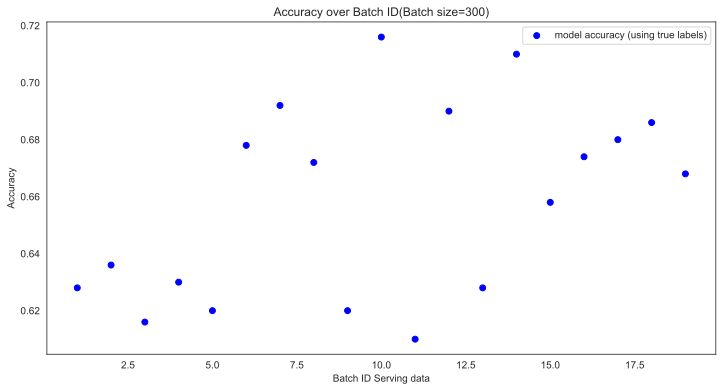

In [315]:
import matplotlib.pyplot as plt

# 设置final_accuracy和accuracy_sample的值，例如这里设置为一些随机值


# 画出折线图，其中x轴为1到5，y轴分别为final_accuracy和accuracy_sample
plt.figure(figsize=(12,6))
#plt.plot(range(1, 51), final_accuracy_list,'o-', color='orange', label='Accuracy_caclulate', alpha=1)
#plt.plot(range(1, 101), accuracy_sample_list, color='green', label='model accuracy (using true labels)',  alpha=0.5)
#plt.scatter(range(1, 101), final_accuracy_list, color='red', label='Accuracy_caclulate')
plt.scatter(range(1, len(accuracy_sample_list)+1), accuracy_sample_list, color='blue', label='model accuracy (using true labels)')
#plt.scatter(range(1, 101), accuracy_sample_list_2, color='blue', label='Retrained real Accuracy points')
#plt.scatter(range(1, 101), accuracy_sample_list, c=['red' if acc < 0.9 else 'none' for acc in accuracy_sample_list], edgecolors='none', label='Points need retrain')
#plt.scatter(range(1, 101), accuracy_sample_list_2, c=['blue' if acc < 0.9 else 'none' for acc in accuracy_sample_list], edgecolors='none', label='Retrained points')

# x = []
# y = []
# for i in range(100):
#     n=i+1
#     if accuracy_sample_list[i] <= 0.9:
#         x.append(n)
#         y.append(accuracy_sample_list[i])
# plt.plot(x, y, 'o-',color='green',  alpha=0.5, label='Points need retrain')

# x = []
# y = []
# for i in range(100):
#     n=i+1
#     if accuracy_sample_list[i] <= 0.9:
#         x.append(n)
#         y.append(accuracy_sample_list_2[i])

# # 将点连接起来
# plt.plot(x, y, 'o-',color='red',  alpha=0.5, label='Retrained points')

# 画阈值线
#plt.axhline(y=0.9, color='red', linestyle='--', label='Threshold')

# 添加图例，横轴和纵轴标签以及标题
plt.legend()
plt.xlabel('Batch ID Serving data')
plt.ylabel('Accuracy')
plt.title('Accuracy over Batch ID(Batch size=300)')

# 显示图像
plt.show()








In [269]:
# plt.figure(figsize=(12,6))
# plt.plot(range(1, 101), accuracy_sample_list_2, color='red', label='accuracy after retrain',  alpha=1)
# #plt.plot(range(1, 101), accuracy_sample_list_2, color='blue', label='accuracy after retrain',  alpha=0.5)
# # 画阈值线
# #plt.axhline(y=0.9, color='red', linestyle='--', label='Threshold')

# x = []
# y = []
# for i in range(100):
#     n=i+1
#     if accuracy_sample_list[i] != accuracy_sample_list_2[i]:
#         x.append(n)
#         y.append(accuracy_sample_list[i])

# # 将点连接起来
# plt.scatter(x, y,color='blue',  alpha=1, label='points need retrain')
# #plt.scatter(range(1, 101), final_accuracy_list, color='red', label='Accuracy_caclulate')

# # 添加图例，横轴和纵轴标签以及标题
# plt.legend()
# plt.xlabel('Batch ID Serving data')
# plt.ylabel('Accuracy')
# plt.title('Accuracy over Batch ID(Batch size=300)')

In [270]:
# count = 0
# for i in range(len(accuracy_sample_list_2)):
#     if accuracy_sample_list_2[i] > accuracy_sample_list[i]:
#         count += 1
# print(f"{count}")

## K_S


In [271]:
# 定义检测函数
def drift_detection(X_train, X_test, threshold=0.05):
    """
    检测数据分布是否漂移
    """
    # 提取特征列表
    features = X_train.columns.tolist()

    # 初始化检测结果列表
    results = []

    # 针对每个特征，计算p-value和KS统计量
    for feature in features:
        # 获取训练数据和测试数据中的该特征的值
        train_values = X_train[feature].values
        test_values = X_test[feature].values

        # 计算KS统计量和p-value
        ks_statistic, p_value = ks_2samp(train_values, test_values)

        # 判断是否漂移
        if p_value < threshold:
            drift = True
        else:
            drift = False

        # 记录检测结果
        results.append({
            "feature": feature,
            "p_value": p_value,
            "ks_statistic": ks_statistic,
            "drift": drift
        })
        

    # 返回结果列表
    return results

In [272]:
import joblib
model = joblib.load("/Users/sdong/phd_doc/att/Fraud/model/model_LR_test_fraud.joblib")

drift_samples_df_1= test_set

drift_samples_df= train_set
new_train_data = pd.concat([X_train_ML,y_train_ML], axis=1, join='inner')

# 初始化检测结果列表
drift_results = []
p_value_list = []
is_drift_list=[]
is_drift=0
# 初始化检测到漂移的样本列表
drift_samples = []
accuracy_sample_list_2 = []
accuracy_sample_list = []
Number_AL_KS=[]
trainingtime_list_KS=[]
count_retrain_KS=0

# 对每个子样本进行检测
for i in range(num_batches):
    # start_index = (i+80) * batch_size
    # end_index = start_index + batch_size
    # service_sample = test_set[start_index:end_index]
    service_sample = drift_samples_df_1.sample(n=batch_size, replace=True, random_state=42
                                              )
    #在原始 DataFrame 中删除已采样的子集
    drift_samples_df_1 = drift_samples_df_1.drop(service_sample.index)
    # 获取当前子样本
    #service_sample = test_df.iloc[i*1000:(i+1)*1000]
    #if i % 2 == 1:
    # 余数为 1，执行操作 1
        #service_sample = drift_samples_df.sample(n=300, replace=False, random_state=42+i)
    #else:
    # 余数为 0，执行操作 2
    #service_sample = drift_samples_df_1.sample(n=100, replace=False, random_state=42+i) 
    Number_AL_KS.append(0)    

    # 获取子样本的特征和标签
    X_service = service_sample.drop(columns=["price"])
    y_service = service_sample['price']
    y_predict = model.predict(X_service)
    #y_predict = (y_predict > 0.5).astype(int)
    acc = accuracy_score(y_service, y_predict)

    print(f"Sample {i}: Accuracy = {acc:.4f}")
    # print(service_sample)

    
    # 检测数据分布是否漂移
    results = drift_detection(new_train_data.drop(columns=["price"]), X_service)

    # 判断是否漂移
    is_drift = any([result["drift"] for result in results])

    accuracy_sample_list_2.append(acc)
    accuracy_sample_list.append(acc)
    # 如果漂移，记录检测到漂移的样本编号
    is_drift_list.append(is_drift)
    if is_drift:
        count_retrain_KS+=1
        new_train_data = pd.concat([new_train_data, service_sample])
        # print(new_train_data)
        # model = LogisticRegression(C=0.05,
        #                    random_state=42,
        #                    solver='lbfgs')
        ###### LightGBM
        # model = LGBMClassifier(num_leaves=31,
        #                        max_depth=5, 
        #                        learning_rate=0.02,
        #                        n_estimators=100,
        #                        subsample = 0.8,
        #                        colsample_bytree =0.8
        #                       )
        # model = RandomForestClassifier(n_estimators=250,
        #                       max_depth=12,
        #                       min_samples_leaf=16,
        #                                random_state=42
        #                       )
        ### XGB
        # model = XGBClassifier(max_depth=6,
        #       n_estimators=100,
        #       min_child_weight=8, 
        #       subsample=0.8, 
        #       learning_rate =0.02,    
        #       seed=42)
#         model = Sequential()
#         model.add(Dense(32, activation='relu', input_dim=1000))
#         model.add(Dropout(0.5))  # 添加 Dropout 层，随机丢弃50%的神经元
#         model.add(Dense(16, activation='relu'))
#         model.add(Dropout(0.5))  # 添加 Dropout 层，随机丢弃50%的神经元
#         model.add(Dense(1, activation='sigmoid'))

#         #     # 编译模型
#         model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model = svm.SVC( C=0.1,random_state=42)        
        x = new_train_data.drop(columns=["price"])
        y = new_train_data['price']
        ##########
        from imblearn.over_sampling import SMOTE
        y = y.astype('int')
        oversample = SMOTE(random_state=42)
        X_balance_re,Y_balance_re = oversample.fit_resample(x,y)
        X_balance_re = pd.DataFrame(X_balance_re, columns = x.columns)
        ############
        start_time = time.time()
        model.fit(X_balance_re, Y_balance_re)
        # 记录结束时间
        end_time = time.time()
        
        # 计算时间差
        elapsed_time = end_time - start_time
        trainingtime_list_KS.append(elapsed_time)
        y_predict_sample = model.predict(service_sample.drop(columns=["price"]))
        #y_predict_sample = (y_predict_sample > 0.5).astype(int)
        y_sample = service_sample['price']
        accuracy_sample = accuracy_score(y_sample, y_predict_sample)
        accuracy_sample_list_2.pop()
        accuracy_sample_list_2.append(accuracy_sample)
        Number_AL_KS.pop()
        Number_AL_KS.append(batch_size)
        print(f"The {i} retrain accuracy_sample: {accuracy_sample}")
        new_train_data = new_train_data.reset_index(drop=True)
    else:
        trainingtime_list_KS.append(0)   
        
        
accuracy_sample_list_2_KS = accuracy_sample_list_2
print(f'KS retrain {count_retrain_KS} times' )
average_acc_KS = sum(accuracy_sample_list_2_KS) / len(accuracy_sample_list_2_KS)
print(f"Average Oue methods: {average_acc_KS}")

Sample 0: Accuracy = 0.6280
The 0 retrain accuracy_sample: 0.64
Sample 1: Accuracy = 0.6220
The 1 retrain accuracy_sample: 0.642
Sample 2: Accuracy = 0.5720
The 2 retrain accuracy_sample: 0.686
Sample 3: Accuracy = 0.6880
The 3 retrain accuracy_sample: 0.706
Sample 4: Accuracy = 0.6840
The 4 retrain accuracy_sample: 0.696
Sample 5: Accuracy = 0.6780
The 5 retrain accuracy_sample: 0.632
Sample 6: Accuracy = 0.6140
The 6 retrain accuracy_sample: 0.632
Sample 7: Accuracy = 0.6160
The 7 retrain accuracy_sample: 0.63
Sample 8: Accuracy = 0.6140
The 8 retrain accuracy_sample: 0.634
Sample 9: Accuracy = 0.6180
The 9 retrain accuracy_sample: 0.636
Sample 10: Accuracy = 0.5960
The 10 retrain accuracy_sample: 0.606
Sample 11: Accuracy = 0.5940
The 11 retrain accuracy_sample: 0.618
Sample 12: Accuracy = 0.6220
The 12 retrain accuracy_sample: 0.634
Sample 13: Accuracy = 0.6260
The 13 retrain accuracy_sample: 0.642
Sample 14: Accuracy = 0.5920
The 14 retrain accuracy_sample: 0.628
Sample 15: Accura

## MMD

In [273]:

import joblib
model = joblib.load("/Users/sdong/phd_doc/att/Fraud/model/model_LR_test_fraud.joblib")

In [274]:
# Compute MMD (maximum mean discrepancy) using numpy and scikit-learn.

import numpy as np
from sklearn import metrics

def mmd_fast(X, Y, gamma=1.0):
    """MMD using rbf (gaussian) kernel (i.e., k(x,y) = exp(-gamma * ||x-y||^2 / 2))

    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]

    Keyword Arguments:
        gamma {float} -- [kernel parameter] (default: {1.0})

    Returns:
        [scalar] -- [MMD value]
    """
    XX = metrics.pairwise.rbf_kernel(X, X, gamma)
    YY = metrics.pairwise.rbf_kernel(Y, Y, gamma)
    XY = metrics.pairwise.rbf_kernel(X, Y, gamma)
    mmd = XX.mean() + YY.mean() - 2 * XY.mean()
        # 根据MMD值判断是否存在数据漂移
    print(f'mmd : {mmd}')
    is_drift_mmd=False
    if mmd > 0.00004:
        is_drift_mmd=True
    return is_drift_mmd

In [275]:
# def mmd_value(X, Y, gamma=1.0):
#     """MMD using rbf (gaussian) kernel (i.e., k(x,y) = exp(-gamma * ||x-y||^2 / 2))

#     Arguments:
#         X {[n_sample1, dim]} -- [X matrix]
#         Y {[n_sample2, dim]} -- [Y matrix]

#     Keyword Arguments:
#         gamma {float} -- [kernel parameter] (default: {1.0})

#     Returns:
#         [scalar] -- [MMD value]
#     """
#     XX = metrics.pairwise.rbf_kernel(X, X, gamma)
#     YY = metrics.pairwise.rbf_kernel(Y, Y, gamma)
#     XY = metrics.pairwise.rbf_kernel(X, Y, gamma)
#     mmd = XX.mean() + YY.mean() - 2 * XY.mean()
#         # 根据MMD值判断是否存在数据漂移

#     return mmd

In [276]:
# print(len(train_set))

In [277]:
# drift_samples_df_2= test_set
# drift_samples_df_3= test_set
# mmd_list=[]
# n=1451
# m=200
# for i in range(100):
    
#     # start_index = i * batch_size
#     # end_index = start_index + batch_size
#     # service_sample = drift_samples_df_1[start_index:end_index]
#     service_sample_2 = df_all.sample(n, replace=True)
#     # 在原始 DataFrame 中删除已采样的子集

#     n=n+200
#     service_sample_3 = df_all.sample(m, replace=True)
#     # 在原始 DataFrame 中删除已采样的子集
    
#     mmd = mmd_value(service_sample_2.drop(columns=["price"]), service_sample_3.drop(columns=["price"]))
#     mmd_list.append(mmd)

# print(mmd_list)


In [278]:
# print(np.mean(mmd_list))
# print(min(mmd_list))

In [279]:

drift_samples_df_1= test_set

drift_samples_df= train_set
new_train_data = pd.concat([X_train_ML,y_train_ML], axis=1, join='inner')

# 初始化检测结果列表
drift_results = []
p_value_list = []
is_drift_list=[]

# 初始化检测到漂移的样本列表
drift_samples = []
accuracy_sample_list_2 = []
accuracy_sample_list = []
Number_AL_MMD=[]
trainingtime_list_MMD=[]
count_retrain_MMD=0

# 对每个子样本进行检测
for i in range(num_batches):
    # start_index = (i+80) * batch_size
    # end_index = start_index + batch_size
    # service_sample = test_set[start_index:end_index]
    service_sample = drift_samples_df_1.sample(n=batch_size, replace=True,random_state=42)
    # 在原始 DataFrame 中删除已采样的子集
    drift_samples_df_1 = drift_samples_df_1.drop(service_sample.index)
    
    
    Number_AL_MMD.append(0)
    

    # 获取子样本的特征和标签
    X_service = service_sample.drop(columns=["price"])
    y_service = service_sample['price']
    y_predict = model.predict(X_service)
    #y_predict = (y_predict > 0.5).astype(int)
    acc = accuracy_score(y_service, y_predict)

    print(f"Sample {i}: Accuracy = {acc:.4f}")

    # 检测数据分布是否漂移

    is_drift = mmd_fast(new_train_data.drop(columns=["price"]), service_sample.drop(columns=["price"]))



    accuracy_sample_list_2.append(acc)
    accuracy_sample_list.append(acc)
    # 如果漂移，记录检测到漂移的样本编号
    is_drift_list.append(is_drift)
    if is_drift:
        count_retrain_MMD+=1
        new_train_data = pd.concat([new_train_data, service_sample])
        # model = LogisticRegression(C=0.05,
        #                    random_state=42,
        #                    solver='lbfgs')
        model = svm.SVC( C=0.1,random_state=42)
                ###### LightGBM
        # model = LGBMClassifier(num_leaves=31,
        #                max_depth=5, 
        #                learning_rate=0.02,
        #                n_estimators=100,
        #                subsample = 0.8,
        #                colsample_bytree =0.8
        #               )
        # model = RandomForestClassifier(n_estimators=250,
        #                       max_depth=12,
        #                       min_samples_leaf=16,
        #                     random_state=42
        #                       )

        # model = XGBClassifier(max_depth=6,
        #       n_estimators=100,
        #       min_child_weight=8, 
        #       subsample=0.8, 
        #       learning_rate =0.02,    
        #       seed=42)
#         model = Sequential()
#         model.add(Dense(32, activation='relu', input_dim=1000))
#         model.add(Dropout(0.5))  # 添加 Dropout 层，随机丢弃50%的神经元
#         model.add(Dense(16, activation='relu'))
#         model.add(Dropout(0.5))  # 添加 Dropout 层，随机丢弃50%的神经元
#         model.add(Dense(1, activation='sigmoid'))

#         #     # 编译模型
#         model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
        
        x = new_train_data.drop(columns=["price"])
        y = new_train_data['price']
        ##########
        from imblearn.over_sampling import SMOTE
        y = y.astype('int')
        oversample = SMOTE(random_state=42)
        X_balance_re,Y_balance_re = oversample.fit_resample(x,y)
        X_balance_re = pd.DataFrame(X_balance_re, columns = x.columns)
        ############
        start_time = time.time()
        model.fit(X_balance_re, Y_balance_re)
        # 记录结束时间
        end_time = time.time()
        
        # 计算时间差
        elapsed_time = end_time - start_time
        trainingtime_list_MMD.append(elapsed_time)
        ###############
        y_predict_sample = model.predict(service_sample.drop(columns=["price"]))
        #y_predict_sample = (y_predict_sample > 0.5).astype(int)
        y_sample = service_sample['price']
        accuracy_sample = accuracy_score(y_sample, y_predict_sample)
        accuracy_sample_list_2.pop()
        accuracy_sample_list_2.append(accuracy_sample)
        Number_AL_MMD.pop()
        Number_AL_MMD.append(batch_size)
        print(f"The {i} retrain accuracy_sample: {accuracy_sample}")
        new_train_data = new_train_data.reset_index(drop=True)
    else:
        trainingtime_list_MMD.append(0)        
        

accuracy_sample_list_MMD=accuracy_sample_list
accuracy_sample_list_2_MMD = accuracy_sample_list_2
print(f'MMD retrain {count_retrain_MMD} times' )

Sample 0: Accuracy = 0.6280
mmd : 0.004778231123004004
The 0 retrain accuracy_sample: 0.64
Sample 1: Accuracy = 0.6220
mmd : 0.003924412607133311
The 1 retrain accuracy_sample: 0.642
Sample 2: Accuracy = 0.5720
mmd : 0.003075998029464108
The 2 retrain accuracy_sample: 0.686
Sample 3: Accuracy = 0.6880
mmd : 0.004034292595071189
The 3 retrain accuracy_sample: 0.706
Sample 4: Accuracy = 0.6840
mmd : 0.0029918460941944502
The 4 retrain accuracy_sample: 0.696
Sample 5: Accuracy = 0.6780
mmd : 0.0021496243579176566
The 5 retrain accuracy_sample: 0.632
Sample 6: Accuracy = 0.6140
mmd : 0.0020899594122467113
The 6 retrain accuracy_sample: 0.632
Sample 7: Accuracy = 0.6160
mmd : 0.0022865477356717387
The 7 retrain accuracy_sample: 0.63
Sample 8: Accuracy = 0.6140
mmd : 0.0022303556114846718
The 8 retrain accuracy_sample: 0.634
Sample 9: Accuracy = 0.6180
mmd : 0.0020573982169734203
The 9 retrain accuracy_sample: 0.636
Sample 10: Accuracy = 0.5960
mmd : 0.0021279303073900926
The 10 retrain accu

## HD

In [280]:
import joblib
model = joblib.load("/Users/sdong/phd_doc/att/Fraud/model/model_LR_test_fraud.joblib")

In [281]:

drift_samples_df_1= test_set

drift_samples_df= train_set
new_train_data = pd.concat([X_train_ML,y_train_ML], axis=1, join='inner')

# 初始化检测结果列表
drift_results = []
p_value_list = []
is_drift_list=[]

# 初始化检测到漂移的样本列表
drift_samples = []
accuracy_sample_list_2 = []
accuracy_sample_list = []
accuracy_before_retrain = []
Number_AL_HD=[]
trainingtime_list_HD=[]
count_retrain_HD=0
# 对每个子样本进行检测
for i in range(num_batches):
    # start_index = i * batch_size
    # end_index = start_index + batch_size
    # service_sample = test_set[start_index:end_index]
    service_sample = drift_samples_df_1.sample(n=batch_size,  replace=True,random_state=42)
    #在原始 DataFrame 中删除已采样的子集
    drift_samples_df_1 = drift_samples_df_1.drop(service_sample.index)

    # 获取当前子样本
    #service_sample = test_df.iloc[i*1000:(i+1)*1000]
    #if i % 2 == 1:
    # 余数为 1，执行操作 1
        #service_sample = drift_samples_df.sample(n=300, replace=False, random_state=42+i)
    #else:
    # 余数为 0，执行操作 2
    #service_sample = drift_samples_df_1.sample(n=100, replace=False, random_state=42+i) 
    Number_AL_HD.append(0)    

    # 获取子样本的特征和标签
    X_service = service_sample.drop(columns=["price"])
    y_service = service_sample['price']
    y_predict = model.predict(X_service)
    #y_predict = (y_predict > 0.5).astype(int)
    acc = accuracy_score(y_service, y_predict)

    
    # 检测数据分布是否漂移
    is_drift = evaluate(new_train_data.drop(columns=["price"]), X_service)
    is_drift_list.append(is_drift)
    
    # 判断是否漂移
    #is_drift = any([result["drift"] for result in results])


    accuracy_sample_list_2.append(acc)
    accuracy_sample_list.append(acc)
    # 如果漂移，记录检测到漂移的样本编号
    is_drift_list.append(is_drift)
    if is_drift:
        count_retrain_HD+=1
        new_train_data = pd.concat([new_train_data, service_sample])
        ###### LogisticRegression

        # model = LogisticRegression(C=0.05,
        #                        random_state=42,
        #                        solver='lbfgs')
        model = svm.SVC( C=0.1,random_state=42)

        ###### LightGBM
        # model = LGBMClassifier(num_leaves=31,
        #                max_depth=5, 
        #                learning_rate=0.02,
        #                n_estimators=100,
        #                subsample = 0.8,
        #                colsample_bytree =0.8
        #               )
        # model = RandomForestClassifier(n_estimators=250,
        #                       max_depth=12,
        #                       min_samples_leaf=16,
        #                                random_state=42
        #                       )
        # model = XGBClassifier(max_depth=6,
        #       n_estimators=100,
        #       min_child_weight=8, 
        #       subsample=0.8, 
        #       learning_rate =0.02,    
        #       seed=42)
        
        
#         model = Sequential()
#         model.add(Dense(32, activation='relu', input_dim=1000))
#         model.add(Dropout(0.5))  # 添加 Dropout 层，随机丢弃50%的神经元
#         model.add(Dense(16, activation='relu'))
#         model.add(Dropout(0.5))  # 添加 Dropout 层，随机丢弃50%的神经元
#         model.add(Dense(1, activation='sigmoid'))

#         #     # 编译模型
#         model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        x = new_train_data.drop(columns=["price"])
        y = new_train_data['price']
        ##########
        y = y.astype('int')
        oversample = SMOTE(random_state=42)
        X_balance_re,Y_balance_re = oversample.fit_resample(x,y)
        X_balance_re = pd.DataFrame(X_balance_re, columns = x.columns)
        ############
        start_time = time.time()
        model.fit(X_balance_re, Y_balance_re)
        # 记录结束时间
        end_time = time.time()
        
        # 计算时间差
        elapsed_time = end_time - start_time
        trainingtime_list_HD.append(elapsed_time)
        y_predict_sample = model.predict(service_sample.drop(columns=["price"]))
        #y_predict_sample = (y_predict_sample > 0.5).astype(int)
        y_sample = service_sample['price']
        accuracy_sample = accuracy_score(y_sample, y_predict_sample)
        accuracy_sample_list_2.pop()
        accuracy_sample_list_2.append(accuracy_sample)
        
        Number_AL_HD.pop()
        Number_AL_HD.append(batch_size)
        print(f"The {i} retrain accuracy_sample: {accuracy_sample}")
        new_train_data = new_train_data.reset_index(drop=True)
    else:
        trainingtime_list_HD.append(0)
        
        

# 将结果保存到CSV文件中

accuracy_sample_list_HD=accuracy_sample_list
accuracy_sample_list_2_HD = accuracy_sample_list_2
print(f'HD retrain {count_retrain_HD} times' )

pos:0
The 0 retrain accuracy_sample: 0.64
pos:0
The 1 retrain accuracy_sample: 0.642
pos:2
The 2 retrain accuracy_sample: 0.686
pos:0
The 3 retrain accuracy_sample: 0.706
pos:0
The 4 retrain accuracy_sample: 0.696
pos:2
The 5 retrain accuracy_sample: 0.632
pos:3
The 6 retrain accuracy_sample: 0.632
pos:99
pos:3
The 8 retrain accuracy_sample: 0.628
pos:2
The 9 retrain accuracy_sample: 0.638
pos:2
The 10 retrain accuracy_sample: 0.614
pos:89
The 11 retrain accuracy_sample: 0.61
pos:0
The 12 retrain accuracy_sample: 0.628
pos:6
The 13 retrain accuracy_sample: 0.724
pos:0
The 14 retrain accuracy_sample: 0.626
pos:8
The 15 retrain accuracy_sample: 0.614
pos:1
The 16 retrain accuracy_sample: 0.654
pos:0
The 17 retrain accuracy_sample: 0.62
pos:1
The 18 retrain accuracy_sample: 0.592
HD retrain 18 times


### baseline: No retrain

In [282]:

drift_samples_df_1= test_set
import joblib
model = joblib.load("/Users/sdong/phd_doc/att/Fraud/model/model_LR_test_fraud.joblib")
accuracy_no_retrain = []
# 对每个子样本进行检测
for i in range(num_batches):
    # start_index = i * batch_size
    # end_index = start_index + batch_size
    # service_sample = test_set[start_index:end_index]
    service_sample = drift_samples_df_1.sample(n=batch_size, replace=True, random_state=42)
        #在原始 DataFrame 中删除已采样的子集
    drift_samples_df_1 = drift_samples_df_1.drop(service_sample.index)
    # 获取当前子样本
    #service_sample = test_df.iloc[i*1000:(i+1)*1000]
    #if i % 2 == 1:
    # 余数为 1，执行操作 1
        #service_sample = drift_samples_df.sample(n=300, replace=False, random_state=42+i)
    #else:
    # 余数为 0，执行操作 2
    #service_sample = drift_samples_df_1.sample(n=100, replace=False, random_state=42+i) 
    

    # 获取子样本的特征和标签
    X_service = service_sample.drop(columns=["price"])
    y_service = service_sample['price']
    y_predict = model.predict(X_service)
    #y_predict = (y_predict > 0.5).astype(int)
    acc = accuracy_score(y_service, y_predict)
    accuracy_no_retrain.append(acc)
    
list7=accuracy_no_retrain

### Baseline: Random sample the same number with out method to retrain

In [283]:
import joblib
model = joblib.load("/Users/sdong/phd_doc/att/Fraud/model/model_LR_test_fraud.joblib")



drift_samples_df_1= test_set

drift_samples_df= train_set
new_train_data = pd.concat([X_train_ML,y_train_ML], axis=1, join='inner')




accuracy_sample_list_2 = []
accuracy_sample_list = []


# 对每个子样本进行检测
for i in range(num_batches):

    # start_index = i * batch_size
    # end_index = start_index + batch_size
    # service_sample = drift_samples_df_1[start_index:end_index]
    # 进行有放回的随机采样
    service_sample = drift_samples_df_1.sample(n=batch_size, replace=True, random_state=42)
    drift_samples_df_1 = drift_samples_df_1.drop(service_sample.index)
    # 获取当前子样本
    #service_sample = test_df.iloc[i*1000:(i+1)*1000]
    #if i % 2 == 1:
    # 余数为 1，执行操作 1
        #service_sample = drift_samples_df.sample(n=300, replace=False, random_state=42+i)
    #else:
    # 余数为 0，执行操作 2
    #service_sample = drift_samples_df_1.sample(n=100, replace=False, random_state=42+i) 
    
    

    

    # 获取子样本的特征和标签
    # 获取子样本的特征和标签
    X_service = service_sample.drop(columns=["price"])
    y_service = service_sample['price']
    y_predict = model.predict(X_service)
    #y_predict = (y_predict > 0.5).astype(int)
    acc = accuracy_score(y_service, y_predict)

    # drift_results.append({
    #     "sample_id": i+1,
    #     # "drift": any([result["drift"] for result in results]),
    #     "bad_drift": bad_drift,
    #     "detect_right": detect_right,
    #     "results": results
    # })
    accuracy_sample_list_2.append(acc)
    accuracy_sample_list.append(acc)
    # 如果漂移，记录检测到漂移的样本编号

    if Number_AL[i]:
        n=Number_AL[i]
        service_sample_choose=service_sample.sample(n, replace=False, random_state=42)

        new_train_data = pd.concat([new_train_data, service_sample_choose])
        ###### LogisticRegression

        # model = LogisticRegression(C=0.05,
        #                        random_state=42,
        #                        solver='lbfgs')
        model = svm.SVC( C=0.1,random_state=42)
        # model = DecisionTreeClassifier(random_state=42
        #                        )
        
        # model = svm.SVC( random_state=42)
        ###### LightGBM

        # model = LGBMClassifier(num_leaves=31,
        #                max_depth=5, 
        #                learning_rate=0.02,
        #                n_estimators=100,
        #                subsample = 0.8,
        #                colsample_bytree =0.8
        #               )
        # model = RandomForestClassifier(n_estimators=250,
        #                       max_depth=12,
        #                       min_samples_leaf=16,
        #                                random_state=42
        #                       )
        
        # model = XGBClassifier(max_depth=6,
        #       n_estimators=100,
        #       min_child_weight=8, 
        #       subsample=0.8, 
        #       learning_rate =0.02,    
        #       seed=42)
#         model = Sequential()
#         model.add(Dense(32, activation='relu', input_dim=1000))
#         model.add(Dropout(0.5))  # 添加 Dropout 层，随机丢弃50%的神经元
#         model.add(Dense(16, activation='relu'))
#         model.add(Dropout(0.5))  # 添加 Dropout 层，随机丢弃50%的神经元
#         model.add(Dense(1, activation='sigmoid'))

#         #     # 编译模型
#         model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        x = new_train_data.drop(columns=["price"])
        y = new_train_data['price']
        ##########
        y = y.astype('int')
        oversample = SMOTE(random_state=42)
        X_balance_re,Y_balance_re = oversample.fit_resample(x,y)
        X_balance_re = pd.DataFrame(X_balance_re, columns = x.columns)
        ############
 
        model.fit(X_balance_re,Y_balance_re)
     
        
        y_predict_sample = model.predict(service_sample.drop(columns=["price"]))
        #y_predict_sample = (y_predict_sample > 0.5).astype(int)
        y_sample = service_sample['price']
        accuracy_sample = accuracy_score(y_sample, y_predict_sample)
        accuracy_sample_list_2.pop()
        accuracy_sample_list_2.append(accuracy_sample)

        print(f"The {i} retrain accuracy_sample: {accuracy_sample}")
        new_train_data = new_train_data.reset_index(drop=True)

        
accuracy_sample_list_baseline_low2=accuracy_sample_list

accuracy_sample_list_2_baseline_low2 = accuracy_sample_list_2

The 0 retrain accuracy_sample: 0.636
The 1 retrain accuracy_sample: 0.628
The 2 retrain accuracy_sample: 0.598
The 3 retrain accuracy_sample: 0.618
The 4 retrain accuracy_sample: 0.692
The 5 retrain accuracy_sample: 0.682
The 6 retrain accuracy_sample: 0.69
The 7 retrain accuracy_sample: 0.678
The 8 retrain accuracy_sample: 0.662
The 9 retrain accuracy_sample: 0.716
The 10 retrain accuracy_sample: 0.694
The 11 retrain accuracy_sample: 0.692
The 12 retrain accuracy_sample: 0.718
The 13 retrain accuracy_sample: 0.718
The 14 retrain accuracy_sample: 0.656
The 15 retrain accuracy_sample: 0.66
The 16 retrain accuracy_sample: 0.674
The 17 retrain accuracy_sample: 0.682
The 18 retrain accuracy_sample: 0.594


##  Real random

In [316]:
import joblib
model = joblib.load("/Users/sdong/phd_doc/att/Fraud/model/model_LR_test_fraud.joblib")



drift_samples_df_1= test_set

drift_samples_df= train_set
new_train_data = pd.concat([X_train_ML,y_train_ML], axis=1, join='inner')

average_number_al = int(sum(Number_AL) / len(Number_AL))


accuracy_sample_list_2 = []
accuracy_sample_list = []
trainingtime_list_real_random=[]

# 对每个子样本进行检测
for i in range(num_batches):
    

    # start_index = i * batch_size
    # end_index = start_index + batch_size
    # service_sample = drift_samples_df_1[start_index:end_index]
    # 进行有放回的随机采样
    service_sample = drift_samples_df_1.sample(n=batch_size, replace=True, random_state=42)
    drift_samples_df_1 = drift_samples_df_1.drop(service_sample.index)
    # 获取当前子样本
    #service_sample = test_df.iloc[i*1000:(i+1)*1000]
    #if i % 2 == 1:
    # 余数为 1，执行操作 1
        #service_sample = drift_samples_df.sample(n=300, replace=False, random_state=42+i)
    #else:
    # 余数为 0，执行操作 2
    #service_sample = drift_samples_df_1.sample(n=100, replace=False, random_state=42+i) 
    
    

    

    # 获取子样本的特征和标签
    # 获取子样本的特征和标签
    X_service = service_sample.drop(columns=["price"])
    y_service = service_sample['price']
    y_predict = model.predict(X_service)
    #y_predict = (y_predict > 0.5).astype(int)
    acc = accuracy_score(y_service, y_predict)

    # drift_results.append({
    #     "sample_id": i+1,
    #     # "drift": any([result["drift"] for result in results]),
    #     "bad_drift": bad_drift,
    #     "detect_right": detect_right,
    #     "results": results
    # })
    accuracy_sample_list_2.append(acc)
    accuracy_sample_list.append(acc)
    # 如果漂移，记录检测到漂移的样本编号


    service_sample_choose=service_sample.sample(average_number_al, replace=False, random_state=42)

    new_train_data = pd.concat([new_train_data, service_sample_choose])
    ###### LogisticRegression

    # model = LogisticRegression(C=0.05,
    #                        random_state=42,
    #                        solver='lbfgs')
    model = svm.SVC( C=0.1,random_state=42)
    # model = DecisionTreeClassifier(random_state=42
    #                        )

    # model = svm.SVC( random_state=42)
    ###### LightGBM

    # model = LGBMClassifier(num_leaves=31,
    #                max_depth=5, 
    #                learning_rate=0.02,
    #                n_estimators=100,
    #                subsample = 0.8,
    #                colsample_bytree =0.8
    #               )
    # model = RandomForestClassifier(n_estimators=250,
    #                       max_depth=12,
    #                       min_samples_leaf=16,
    #                                random_state=42
    #                       )

    # model = XGBClassifier(max_depth=6,
    #       n_estimators=100,
    #       min_child_weight=8, 
    #       subsample=0.8, 
    #       learning_rate =0.02,    
    #       seed=42)       
#     model = Sequential()
#     model.add(Dense(32, activation='relu', input_dim=1000))
#     model.add(Dropout(0.5))  # 添加 Dropout 层，随机丢弃50%的神经元
#     model.add(Dense(16, activation='relu'))
#     model.add(Dropout(0.5))  # 添加 Dropout 层，随机丢弃50%的神经元
#     model.add(Dense(1, activation='sigmoid'))

#     #     # 编译模型
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    x = new_train_data.drop(columns=["price"])
    y = new_train_data['price']
    ##########
    y = y.astype('int')
    oversample = SMOTE(random_state=42)
    X_balance_re,Y_balance_re = oversample.fit_resample(x,y)
    X_balance_re = pd.DataFrame(X_balance_re, columns = x.columns)
    ############

    ############
    start_time = time.time()
    model.fit(X_balance_re, Y_balance_re)
    # 记录结束时间
    end_time = time.time()

    # 计算时间差
    elapsed_time = end_time - start_time
    trainingtime_list_real_random.append(elapsed_time)


    y_predict_sample = model.predict(service_sample.drop(columns=["price"]))
    #y_predict_sample = (y_predict_sample > 0.5).astype(int)
    y_sample = service_sample['price']
    accuracy_sample = accuracy_score(y_sample, y_predict_sample)
    accuracy_sample_list_2.pop()
    accuracy_sample_list_2.append(accuracy_sample)

    print(f"The {i} retrain accuracy_sample: {accuracy_sample}")
    new_train_data = new_train_data.reset_index(drop=True)

        
accuracy_sample_list_baseline_real_low2=accuracy_sample_list

accuracy_sample_list_2_real_baseline_low2 = accuracy_sample_list_2

The 0 retrain accuracy_sample: 0.636
The 1 retrain accuracy_sample: 0.622
The 2 retrain accuracy_sample: 0.598
The 3 retrain accuracy_sample: 0.618
The 4 retrain accuracy_sample: 0.612
The 5 retrain accuracy_sample: 0.636
The 6 retrain accuracy_sample: 0.694
The 7 retrain accuracy_sample: 0.672
The 8 retrain accuracy_sample: 0.656
The 9 retrain accuracy_sample: 0.716
The 10 retrain accuracy_sample: 0.702
The 11 retrain accuracy_sample: 0.688
The 12 retrain accuracy_sample: 0.722
The 13 retrain accuracy_sample: 0.636
The 14 retrain accuracy_sample: 0.656
The 15 retrain accuracy_sample: 0.666
The 16 retrain accuracy_sample: 0.678
The 17 retrain accuracy_sample: 0.686
The 18 retrain accuracy_sample: 0.674


In [317]:
average_acc = sum(accuracy_sample_list_2_real_baseline_low2) / len(accuracy_sample_list_2_real_baseline_low2)
print(f"Average Oue methods: {average_acc}")

Average Oue methods: 0.6614736842105263


In [307]:
# accuracy_sample_list_2_HD=accuracy_sample_list_2

list4=accuracy_sample_list_2_MMD
list3=accuracy_sample_list_2_KS
list1=accuracy_sample_list_2_DDLA
list2=accuracy_sample_list_2_HD
list5=accuracy_sample_list_2_baseline_low2
list8=accuracy_sample_list_2_real_baseline_low2
# list5=accuracy_sample_list_HD
# list6=accuracy_sample_list_DDLA

In [308]:
#accuracy_sample_list_2 = pd.DataFrame(accuracy_sample_list_2, columns=['accuracy'])
#accuracy_sample_list_2.to_csv('/Users/sdong/phd_doc/att/weather_data/accuracy_sample_list_2.csv')

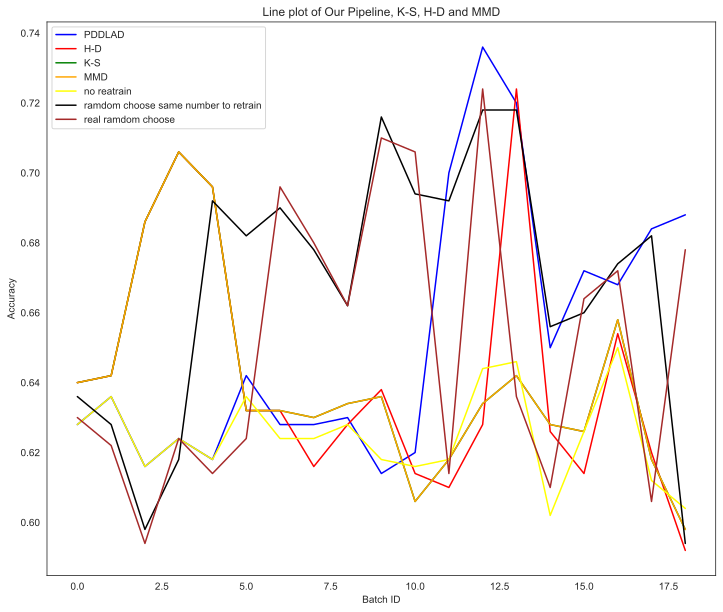

Average Oue methods: 0.6527368421052632
Average KS: 0.6401052631578947
Average MMD: 0.6401052631578947
Average HD: 0.6419999999999999
Average no retrain: 0.6247368421052631
Average ramdom choose retrain: 0.6677894736842106
real ramdom choose retrain: 0.6508421052631578
10


In [309]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
x_axis = list(range(len(list1)))

plt.plot(x_axis, list1, color='blue', label='PDDLAD')
plt.plot(x_axis, list2, color='red', label='H-D')
plt.plot(x_axis, list3, color='green', label='K-S')
plt.plot(x_axis, list4, color='orange', label='MMD')
#plt.plot(x_axis, list5, color='green', label='before retrain HD')
# plt.plot(x_axis, list6, color='orange', label='before reatrain DDLA')
plt.plot(x_axis, list7, color='yellow', label='no reatrain')
plt.plot(x_axis, list5, color='black', label='ramdom choose same number to retrain')
plt.plot(x_axis, list8, color='brown', label='real ramdom choose ')
plt.legend()

plt.xlabel('Batch ID')
plt.ylabel('Accuracy')
plt.title('Line plot of Our Pipeline, K-S, H-D and MMD')

plt.show()

average_list1 = sum(list1) / len(list1)
print(f"Average Oue methods: {average_list1}")
average_list3 = sum(list3) / len(list3)
print(f"Average KS: {average_list3}")
average_list4 = sum(list4) / len(list4)
print(f"Average MMD: {average_list4}")
average_list2 = sum(list2) / len(list2)
print(f"Average HD: {average_list2}")
average_list7 = sum(list7) / len(list7)
print(f"Average no retrain: {average_list7}")
average_list5 = sum(list5) / len(list5)
print(f"Average ramdom choose retrain: {average_list5}")
average_list8 = sum(list8) / len(list8)
print(f"real ramdom choose retrain: {average_list8}")
count = sum(x > y for x, y in zip(list1, list3))
print(count)

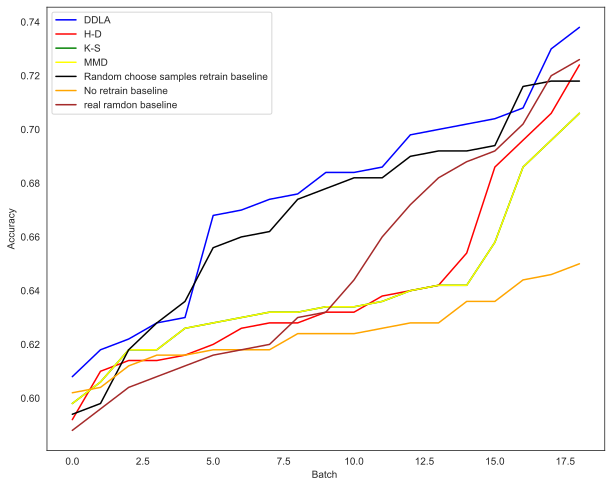

In [289]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
x_axis = list(range(len(list1)))

plt.plot(x_axis, np.sort(list1), color='blue', label='DDLA')
plt.plot(x_axis, np.sort(list2), color='red', label='H-D')
plt.plot(x_axis, np.sort(list3), color='green', label='K-S')
plt.plot(x_axis, np.sort(list4), color='yellow', label='MMD')
plt.plot(x_axis, np.sort(list5), color='black', label='Random choose samples retrain baseline')
plt.plot(x_axis, np.sort(list7), color='orange', label='No retrain baseline')
plt.plot(x_axis, np.sort(list8), color='brown', label='real ramdon baseline')


plt.legend()

plt.xlabel('Batch ')
plt.ylabel('Accuracy')
#plt.title('Line plot of Our Pipeline, K-S, H-D and MMD')

plt.show()

In [290]:
# # 将准确率值分成20个区间
# bins = np.linspace(0.7, 0.95, 21)

# # 计算频率
# hist1, _ = np.histogram(list1, bins=bins, density=True)
# hist2, _ = np.histogram(list3, bins=bins, density=True)

# # 计算累加频率
# cumulative_hist1 = np.cumsum(hist1)
# cumulative_hist2 = np.cumsum(hist2)

# # 绘制曲线图
# plt.plot(cumulative_hist1, bins[:-1], label='PDDLA')
# plt.plot(cumulative_hist2, bins[:-1], label='KS')

# # 添加图例和标签
# plt.legend(loc='lower right')
# plt.xlabel('Cumulative Frequency')
# plt.ylabel('Accuracy')

# # 显示图形
# plt.show()

In [291]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(20,12))
# x_axis = list(range(len(list1)))
# print(len(list1))
# plt.plot(x_axis, np.sort(list1), color='blue', label='PDDLAD')
# #plt.plot(x_axis, list2, color='red', label='H-D')
# plt.plot(x_axis, np.asarray(list3)[np.argsort(list1)], color='green', label='K-S')
# #plt.plot(x_axis, np.asarray(list4)[np.argsort(list1)], color='orange', label='MMD')
# plt.legend()

# plt.xlabel('Batch ID')
# plt.ylabel('Accuracy')
# plt.title('Line plot of Our Pipeline, K-S, H-D and MMD')

# plt.show()


In [292]:
# parameter1 = np.polyfit(x_axis, list1, 10)
# p1 = np.poly1d(parameter1)
# #plt.scatter(x_axis, list1)
# # parameter2 = np.polyfit(x_axis, list2, 10)
# # p2 = np.poly1d(parameter2)
# #plt.scatter(x_axis, list1)
# parameter3 = np.polyfit(x_axis, list3, 10)
# p3 = np.poly1d(parameter3)
# #plt.scatter(x_axis, list1)
# parameter4 = np.polyfit(x_axis, list4, 10)
# p4 = np.poly1d(parameter4)
# #plt.scatter(x_axis, list1)


# plt.plot(x_axis, p1(x_axis), color='blue', label='PDDLAD')
# #plt.plot(x_axis, p2(x_axis), color='red', label='H-D')
# plt.plot(x_axis, p3(x_axis), color='green', label='K-S')
# plt.plot(x_axis, p4(x_axis), color='orange', label='MMD')

# plt.legend()

# plt.xlabel('Batch ID')
# plt.ylabel('Accuracy')
# plt.title('Line plot of Our Pipeline, K-S, H-D and MMD')
# plt.show()

19


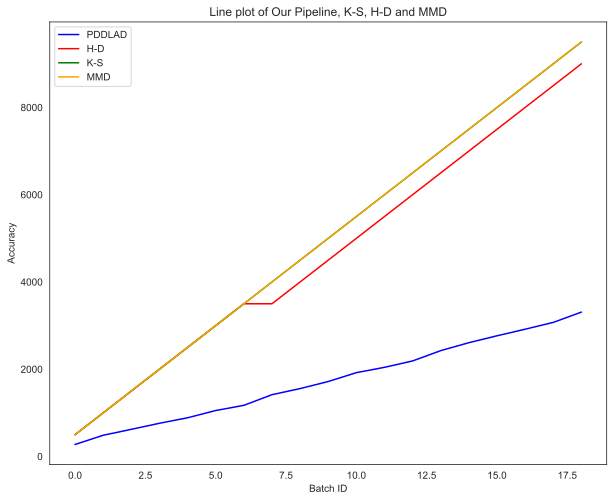

PDDLA the number that expert labeled: 3309
KS the number that expert labeled: 9500
HD the number that expert labeled: 9000
MMD the number that expert labeled: 9500


In [293]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
x_axis = list(range(len(Number_AL)))
# 对x进行累加
print(len(Number_AL))
Number_AL_cumsum = np.cumsum(Number_AL)
Number_AL_KS_cumsum = np.cumsum(Number_AL_KS)
Number_AL_MMD_cumsum = np.cumsum(Number_AL_MMD)
Number_AL_HD_cumsum = np.cumsum(Number_AL_HD)
# print(Number_AL_cumsum.shape)
# print(Number_AL_KS_cumsum)
plt.plot(x_axis, Number_AL_cumsum, color='blue', label='PDDLAD')
plt.plot(x_axis, Number_AL_HD_cumsum, color='red', label='H-D')
plt.plot(x_axis, Number_AL_KS_cumsum, color='green', label='K-S')
plt.plot(x_axis, Number_AL_MMD_cumsum, color='orange', label='MMD')
plt.legend()

plt.xlabel('Batch ID')
plt.ylabel('Accuracy')
plt.title('Line plot of Our Pipeline, K-S, H-D and MMD')

plt.show()
print(f"PDDLA the number that expert labeled: {Number_AL_cumsum[-1]}")
print(f"KS the number that expert labeled: {Number_AL_KS_cumsum[-1]}")
print(f"HD the number that expert labeled: {Number_AL_HD_cumsum[-1]}")
print(f"MMD the number that expert labeled: {Number_AL_MMD_cumsum[-1]}")

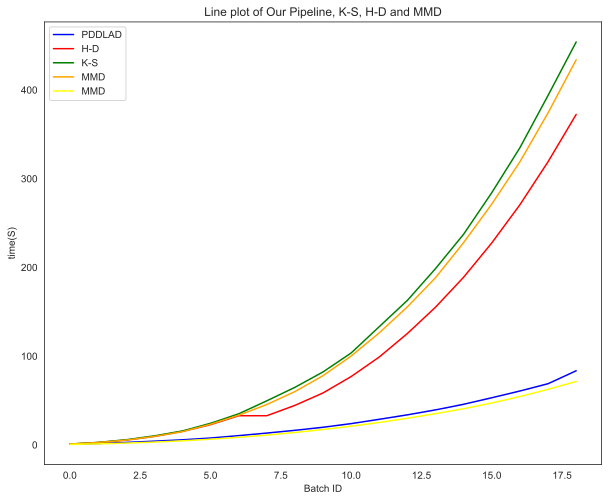

PDDLA retraining time: 83.5236566066742
KS retraining time: 454.04459023475647
MMD retraining time: 433.9519112110138
HD retraining time: 372.3945121765137
real ramdom retraining time: 71.49183440208435


In [294]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
x_axis = list(range(len(trainingtime_list)))
# 对x进行累加
#print(len(Number_AL))
trainingtime_list_cumsum = np.cumsum(trainingtime_list)
trainingtime_list_KS_cumsum = np.cumsum(trainingtime_list_KS)
trainingtime_list_MMD_cumsum = np.cumsum(trainingtime_list_MMD)
trainingtime_list_HD_cumsum = np.cumsum(trainingtime_list_HD)
trainingtime_list_real_random_cumsum = np.cumsum(trainingtime_list_real_random)

plt.plot(x_axis, trainingtime_list_cumsum, color='blue', label='PDDLAD')
plt.plot(x_axis, trainingtime_list_HD_cumsum, color='red', label='H-D')
plt.plot(x_axis, trainingtime_list_KS_cumsum, color='green', label='K-S')
plt.plot(x_axis, trainingtime_list_MMD_cumsum, color='orange', label='MMD')
plt.plot(x_axis, trainingtime_list_real_random_cumsum, color='yellow', label='MMD')
plt.legend()

plt.xlabel('Batch ID')
plt.ylabel('time(S)')
plt.title('Line plot of Our Pipeline, K-S, H-D and MMD')

plt.show()

print(f"PDDLA retraining time: {trainingtime_list_cumsum[-1]}")
print(f"KS retraining time: {trainingtime_list_KS_cumsum[-1]}")
print(f"MMD retraining time: {trainingtime_list_MMD_cumsum[-1]}")
print(f"HD retraining time: {trainingtime_list_HD_cumsum[-1]}")
print(f"real ramdom retraining time: {trainingtime_list_real_random_cumsum[-1]}")